In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Titanic analysis

In [3]:
titanic_train_df = pd.read_csv("datasets/benchmark/titanic_clean_train.csv")

X_titanic_train = titanic_train_df.loc[:, titanic_train_df.columns != "Survived"]
Y_titanic_train = titanic_train_df["Survived"]

titanic_test_df = pd.read_csv("datasets/benchmark/titanic_clean_test.csv")
X_titanic_test = titanic_test_df.loc[:, titanic_test_df.columns != "Survived"]
Y_titanic_test = titanic_test_df["Survived"]

# Common Functions

In [4]:
def square_loss(y_true, y_pred):
    n = y_true.shape[0]
    return np.sum((y_pred - y_true) ** 2) / n

def rank_feature_importance(feature_name, feature_score):
    n = feature_name.shape[0]
    lst = [(feature_name[i], feature_score[i]) for i in range(n)]
    lst.sort(key=lambda x:x[1], reverse=True)
    # uncomment to see just the rank without the score
    # return [x[0] for x in lst]
    return lst

def select_features_filter(all_features, target_features):
    lst = []
    for i in range(len(all_features)):
        if all_features[i] in target_features:
            lst.append(True)
        else:
            lst.append(False)
    return lst

# Random Forest

In [6]:
from sklearn.ensemble import RandomForestClassifier

In [7]:
# Observation: when n_estimators=100 the ranked_importance changes!
n_estimators = 1000
for i in range(1):
    rf_clf = RandomForestClassifier(random_state=i, n_estimators=n_estimators)
    rf_clf.fit(X_titanic_train, Y_titanic_train)
    y_pred = rf_clf.predict(X_titanic_test)
    loss = square_loss(Y_titanic_test, y_pred)
    print(f"random state = {i}")
    print(f"loss = {loss}")
    ranked_importance = rank_feature_importance(X_titanic_train.columns, rf_clf.feature_importances_)
    print(ranked_importance)

random state = 0
loss = 0.17557251908396945
[('Sex_male', 0.22473451883413362), ('Sex_female', 0.21374551395389946), ('Fare', 0.185712012840018), ('Age', 0.18046392969419162), ('Pclass', 0.03970342516597053), ('SibSp', 0.03555334084220149), ('Parch', 0.03407583637504626), ('CabinType_NaN', 0.022818127600645412), ('Embarked_S', 0.010447390651346436), ('HasTitle', 0.010292541532967329), ('Embarked_C', 0.009608319742815036), ('CabinType_E', 0.0064260525557639295), ('CabinType_C', 0.005968643629024395), ('CabinType_D', 0.0049583785761439835), ('Embarked_Q', 0.004920024334058026), ('CabinType_B', 0.0042409802189396235), ('CabinType_F', 0.002836877248664754), ('CabinType_A', 0.0025563772627005127), ('CabinType_G', 0.0008005644385104548), ('CabinType_T', 0.00013714450295896854)]


In [11]:
all_features = list(X_titanic_train.columns)
ranked_features = [ x[0] for x in ranked_importance]

random_states = [0]
num_estimators = 100

square_loss_matrix = np.zeros((len(random_states), len(ranked_features)))
for i in range(len(random_states)):
    print(f"random state = {i}")
    rs = random_states[i]
    square_loss_lst = []
    for j in range(1, len(ranked_features) + 1):
        target_features = ranked_features[:j]
        features_filter = select_features_filter(all_features, target_features)
        X_titanic_train_selected_features = X_titanic_train.loc[:, features_filter]
        X_titanic_test_selected_features = X_titanic_test.loc[:, features_filter]
        rf_clf = RandomForestClassifier(random_state=rs, n_estimators=num_estimators)
        rf_clf.fit(X_titanic_train_selected_features, Y_titanic_train)
        square_loss_value = square_loss(Y_titanic_test, rf_clf.predict(X_titanic_test_selected_features))
        square_loss_lst.append(square_loss_value)
    square_loss_matrix[i,:] = np.array(square_loss_lst)

random state = 0


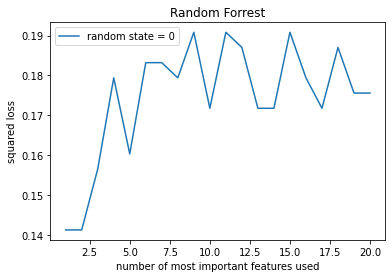

In [12]:
x_axis = np.arange(1, len(ranked_features) + 1)
for i in range(len(random_states)):
    plt.plot(x_axis,square_loss_matrix[i], label=f"random state = {i}")
plt.xlabel("number of most important features used")
plt.ylabel("squared loss")
plt.title("Random Forrest")
plt.legend()
plt.show()

# Random forest selected features
Select top 8 performs almost as well as the complete set of features

In [71]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC


rf_selected_features = [x[0] for x in ranked_importance[:8]]
num_features = len(rf_selected_features)
X_titanic_train_selected_features = X_titanic_train.loc[:, rf_selected_features]
X_titanic_test_selected_features = X_titanic_test.loc[:, rf_selected_features]

print(f"{num_features} significant RF features with RF classifer ------")
num_estimators = 1000
rf_clf = RandomForestClassifier(random_state=rs, n_estimators=num_estimators)
rf_clf.fit(X_titanic_train_selected_features, Y_titanic_train)
y_pred = rf_clf.predict(X_titanic_test_selected_features)

acc = accuracy_score(Y_titanic_test, y_pred)
print(f"accuracy = {acc}")

f1 = f1_score(Y_titanic_test, y_pred)
print(f"f1 score = {f1}")

con_matrix = confusion_matrix(Y_titanic_test, y_pred)
print(f"confusion_matrix = {con_matrix}")

print(f"{num_features} significant RF features with Ridge classifer -----")
ridge_clf = RidgeClassifier()
ridge_clf.fit(X_titanic_train_selected_features, Y_titanic_train)
y_pred = ridge_clf.predict(X_titanic_test_selected_features)

acc = accuracy_score(Y_titanic_test, y_pred)
print(f"accuracy = {acc}")

f1 = f1_score(Y_titanic_test, y_pred)
print(f"f1 score = {f1}")

con_matrix = confusion_matrix(Y_titanic_test, y_pred)
print(f"confusion_matrix = {con_matrix}")

print(f"{num_features} significant RF features with SVC Classifer -----")
svc_clf = SVC()
svc_clf.fit(X_titanic_train_selected_features, Y_titanic_train)
y_pred = svc_clf.predict(X_titanic_test_selected_features)

acc = accuracy_score(Y_titanic_test, y_pred)
print(f"accuracy = {acc}")

f1 = f1_score(Y_titanic_test, y_pred)
print(f"f1 score = {f1}")

con_matrix = confusion_matrix(Y_titanic_test, y_pred)
print(f"confusion_matrix = {con_matrix}")


8 significant RF features with RF classifer ------
accuracy = 0.815625
f1 score = 0.8195718654434252
confusion_matrix = [[127  21]
 [ 38 134]]
8 significant RF features with Ridge classifer -----
accuracy = 0.74375
f1 score = 0.74375
confusion_matrix = [[119  29]
 [ 53 119]]
8 significant RF features with SVC Classifer -----
accuracy = 0.621875
f1 score = 0.7012345679012346
confusion_matrix = [[ 57  91]
 [ 30 142]]


# Lasso Feature Selection

In [13]:
from sklearn import linear_model
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import normalize

In [18]:
def select_feature(all_features, feature_filter):
    lst = []
    for i in range(len(feature_filter)):
        
        if feature_filter[i]:
            lst.append(all_features[i])
    return lst

n = 10
loss_lst = []
features_used = []
alphas = np.linspace(0.00001,0.001,15)
for a in alphas:
    # print(f"a = {a} =========")
    lasso_clf = linear_model.Lasso(alpha=a, normalize=True, random_state=1)
    lasso_clf.fit(X_titanic_train, Y_titanic_train)
    feature_filter = ~np.isclose(lasso_clf.coef_, 0)
    selected_features = select_feature(X_titanic_train.columns, feature_filter)
    print(len(selected_features))
    print(selected_features)
    y_pred = lasso_clf.predict(X_titanic_test)
    loss = square_loss(Y_titanic_test, y_pred)
    loss_lst.append(loss)
    features_used.append(np.sum(feature_filter))
    # print(f"loss = {loss}")

17
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'HasTitle', 'Sex_female', 'CabinType_A', 'CabinType_C', 'CabinType_D', 'CabinType_E', 'CabinType_F', 'CabinType_G', 'CabinType_NaN', 'CabinType_T', 'Embarked_C', 'Embarked_S']
17
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'HasTitle', 'Sex_female', 'CabinType_A', 'CabinType_C', 'CabinType_D', 'CabinType_E', 'CabinType_F', 'CabinType_G', 'CabinType_NaN', 'CabinType_T', 'Embarked_C', 'Embarked_S']
14
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'HasTitle', 'Sex_female', 'CabinType_D', 'CabinType_E', 'CabinType_F', 'CabinType_NaN', 'CabinType_T', 'Embarked_C', 'Embarked_S']
14
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'HasTitle', 'Sex_female', 'CabinType_D', 'CabinType_E', 'CabinType_F', 'CabinType_NaN', 'CabinType_T', 'Embarked_C', 'Embarked_S']
13
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'HasTitle', 'Sex_female', 'CabinType_D', 'CabinType_E', 'CabinType_F', 'CabinType_NaN', 'Embarked_C', 'Embarked_S']
12
['Pclass', 'Age', 'SibSp', 'Parc

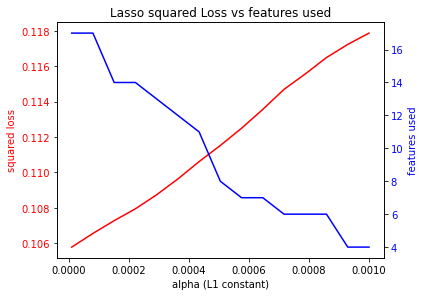

In [19]:
fig, ax1 = plt.subplots()

color = 'red'
ax1.set_xlabel('alpha (L1 constant)')
ax1.set_ylabel('squared loss', color=color)
ax1.plot(alphas, loss_lst, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'blue'
ax2.set_ylabel('features used', color=color)  # we already handled the x-label with ax1
ax2.plot(alphas, features_used, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Lasso squared Loss vs features used")

plt.show()

# LASSO selected features

['volatile acidity', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'sulphates', 'alcohol']
Random forest didn't use 'free sulfur dioxide'

In [20]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC

lasso_selected_features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'HasTitle', 'Sex_female', 'CabinType_D', 'CabinType_E', 'CabinType_F', 'CabinType_NaN', 'CabinType_T', 'Embarked_C', 'Embarked_S']
num_features = len(lasso_selected_features)
X_titanic_train_selected_features = X_titanic_train.loc[:, lasso_selected_features]
X_titanic_test_selected_features = X_titanic_test.loc[:, lasso_selected_features]

print(f"{num_features} significant LASSO features with RF classifer ------")
num_estimators = 10
rf_clf = RandomForestClassifier(random_state=rs, n_estimators=num_estimators)
rf_clf.fit(X_titanic_train_selected_features, Y_titanic_train)
y_pred = rf_clf.predict(X_titanic_test_selected_features)

acc = accuracy_score(Y_titanic_test, y_pred)
print(f"accuracy = {acc}")

f1 = f1_score(Y_titanic_test, y_pred)
print(f"f1 score = {f1}")

con_matrix = confusion_matrix(Y_titanic_test, y_pred)
print(f"confusion_matrix = {con_matrix}")

print(f"{num_features} significant LASSO features with Ridge classifer -----")
ridge_clf = RidgeClassifier()
ridge_clf.fit(X_titanic_train_selected_features, Y_titanic_train)
y_pred = ridge_clf.predict(X_titanic_test_selected_features)

acc = accuracy_score(Y_titanic_test, y_pred)
print(f"accuracy = {acc}")

f1 = f1_score(Y_titanic_test, y_pred)
print(f"f1 score = {f1}")

con_matrix = confusion_matrix(Y_titanic_test, y_pred)
print(f"confusion_matrix = {con_matrix}")

print(f"{num_features} significant LASSO features with SVC Classifer -----")
svc_clf = SVC()
svc_clf.fit(X_titanic_train_selected_features, Y_titanic_train)
y_pred = svc_clf.predict(X_titanic_test_selected_features)

acc = accuracy_score(Y_titanic_test, y_pred)
print(f"accuracy = {acc}")

f1 = f1_score(Y_titanic_test, y_pred)
print(f"f1 score = {f1}")

con_matrix = confusion_matrix(Y_titanic_test, y_pred)
print(f"confusion_matrix = {con_matrix}")

14 significant LASSO features with RF classifer ------
accuracy = 0.8053435114503816
f1 score = 0.7437185929648241
confusion_matrix = [[137  19]
 [ 32  74]]
14 significant LASSO features with Ridge classifer -----
accuracy = 0.8625954198473282
f1 score = 0.8163265306122449
confusion_matrix = [[146  10]
 [ 26  80]]
14 significant LASSO features with SVC Classifer -----
accuracy = 0.6259541984732825
f1 score = 0.3287671232876712
confusion_matrix = [[140  16]
 [ 82  24]]
